Mod from v2 adding variational output

In [1]:
AEversion = '3'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Tue Jul  9 03:25:31 2019
[0] GeForce GTX 1080 | 22'C,   0 % |   486 /  8119 MB | ocerri(475M)
[1] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 25'C,   0 % |   637 /  8119 MB | ocerri(627M)
[3] GeForce GTX 1080 | 34'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 25'C,   0 % |  1462 /  8119 MB | ocerri(1451M)
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve, ELU_ProbNorm

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190708_50part_PtOrder_v2/{}.npy', N_part=20, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e7)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 3.38M train
Expected 3.38M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  4000k   | 2000k | 2000k |
|  qcd   |  1166k   | 1142k | 1142k |
|  Zll   |  1000k   |  226k |  226k |
| ttbar  |  1000k   |  10k  |  10k  |
+--------+----------+-------+-------+
Tot training 3.38 M
Tot val 3.38 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (681.8k)
Loading hChToTauNu (338.5k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=(self.p+3)*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p+3)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        sig_pt = 1. + 1e-6 + F.elu(x_raw[:,:,1]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,2], min_val=-5, max_val=5).view(-1, self.No, 1)
        sig_eta = 1. + 1e-6 + F.elu(x_raw[:,:,3]).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,4]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        sig_phi = 1. + 1e-6 + F.elu(x_raw[:,:,5]).view(-1, self.No, 1)
        # charge
#         charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        charge_cat = ELU_ProbNorm(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        # pId
#         pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        pId_cat = ELU_ProbNorm(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        
        x = torch.cat((pt, eta, phi, sig_pt, sig_eta, sig_phi, charge_cat, pId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [12]:
Latent_dimension = int(2*dataset.inputs.shape[1])
Hidden_dimension = int(0.5*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=100, out_features=70, bias=True)
      (1): ReLU()
      (2): Linear(in_features=70, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=40, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=40, out_features=70, bias=True)
      (1): ReLU()
      (2): Linear(in_features=70, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=160, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 34124


In [13]:
model.useGPU(int(AEversion))

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Tue Jul  9 03:25:56 2019
[0] GeForce GTX 1080 | 21'C,   0 % |   486 /  8119 MB | ocerri(475M)
[1] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 25'C,   0 % |   637 /  8119 MB | ocerri(627M)
[3] GeForce GTX 1080 | 34'C,   4 % |   468 /  8119 MB | ocerri(457M)
[4] GeForce GTX 1080 | 25'C,   0 % |  1462 /  8119 MB | ocerri(1451M)
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 26'C,   0 % |    11 /  8119 MB |


## Loss

In [14]:
def criterion(x_in, x_out, reduction='mean'):
    # Gaussian
    out_gauss = torch.pow((x_in[:,:,:3] - x_out[:,:,:3])/ x_out[:,:,3:6], 2) + torch.log(x_out[:,:,3:6])
    out = torch.sum(out_gauss, dim=2)
    
    #Cat cross entropy charge
    aux = torch.log(x_out[:,:,6:9]).view(-1, 3)
    aux = F.nll_loss(aux, 1+x_in[:,:,3].view(-1).long(), reduction='none')
    out += aux.view(-1, x_in.shape[1])
    
    #Cat cross entropy pId
    aux = torch.log(x_out[:,:,9:14]).view(-1, 5)
    out += F.nll_loss(aux, x_in[:,:,4].view(-1).long(), reduction='none').view(-1, x_in.shape[1])
    
    out_per_evt = torch.sum(out, dim=1)
    
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [15]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 500

eval_params = {'batch_size': 50000,
               'num_workers': 3
              }

In [16]:
# torch.autograd.set_detect_anomaly(True);

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [18]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': []}
optimizer.zero_grad()
try:
    for epoch in range(max_epochs):
        batch_loss = []

        #### ---- Training ---- ####
        model.train()
        dataset.charge(dataset.SMMix_train)
        train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
        pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)

            x_prime = model(local_x)        
            loss = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid training loss!!!')
                raise NameError('LossNAN')
            batch_loss.append(loss.item())

            tail_label = 'Loss: {:2.2e}'.format(loss.item())
            if len(loss_history['train']) > 0:
                tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
            pb.show(len(batch_loss)-1, tail_label=tail_label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        aux_loss = 0
        N_batches = 0
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss = criterion(local_x, x_prime)
            aux_loss += loss.item()
            N_batches += 1
        batch_loss.append(aux_loss/N_batches)

        printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
        if len(loss_history['train']) > 0:
            printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
        if len(loss_history['train']) > 1:
            d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
            printout +=' - Trend: {:2.2e}'.format(d2L_de2)
        print(printout)

        loss_history['train'].append(batch_loss)

        #### ---- Validation ---- ####
        dataset.charge(dataset.SMMix_val)
        val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
        aux_loss = 0
        N_batches = 0
        for local_x, _ in val_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid validation loss!!!')
                raise NameError('LossNAN')
            aux_loss += loss.item()
            N_batches += 1
        loss_history['val'].append(aux_loss/N_batches)
        printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
        print(printout)
        if epoch > 0:
            if loss_history['val'][-1] < np.min(loss_history['val']):
                print('[INFO]: Saving best model')
                torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')

        print('')
        if not earlyStopping.check(loss_history['val'][-1]):
            break

        scheduler.step(batch_loss[-1])

        #### ---- Anomaly Detection monitor ---- ####
        if epoch%3 == 0:
            print('------------ Anomaly Detection monitor ------------')
            BSM_eff['ep'].append(epoch)
            dataset.loss['SMMix'] = np.zeros((0))

            pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
            for i, (local_x, _) in enumerate(val_data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))

            p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
            if not 'p_SM' in BSM_eff.keys():
                BSM_eff['p_SM'] = p_SM
            q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)

            table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))

            for n in dataset.BSM_names:
                dataset.loss[n] = np.zeros((0))

                dataset.charge(dataset.valSamples[n])
                data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
                pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
                for i, (local_x, _) in enumerate(data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

                out = dataset.loss[n] > np.atleast_2d(q_SM).T
                p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
                BSM_eff[n].append(p_BSM)

                table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
            print(table)                
            print('---------------------------------------------------\n\n')

    model.eval()
    torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');
except NameError:
    if epoch > 0:
        print ('\n\nModel ended up nan. Recovering best model\n')
        model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_best.pkl'))
    else:
        raise

Epoch 0: [####################]  100% - Tot. time: 13.8 s           
Loss: 6.35e+01
Val Loss: 6.36e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.2 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.6 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.29e-05 | 2.24e-03 | 2.17e-02 |
| leptoquark | 1.83e-05 | 5.12e-04 | 5.46e-03 |
| hToTauTau  | 1.50e-04 | 2.16e-03 | 1.44e-02 |
| hChToTauNu | 2.13e-04 | 2.99e-03 | 1.85e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 13.8 s                       
Loss: 5.28e+01 - Delta: -1.07e+01
Val Loss: 5.29e+01

Epoch 2: [####################] 

Val Loss: 3.60e+01

Epoch 21: [####################]  100% - Tot. time: 17.4 s                       
Loss: 1.93e+01 - Delta: -1.65e+01 - Trend: -2.96e+01
Val Loss: 1.94e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 20.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.07e-03 | 1.12e-02 | 6.66e-02 |
| leptoquark | 2.27e-04 | 1.83e-03 | 1.86e-02 |
| hToTauTau  | 5.13e-04 | 4.89e-03 | 4.39e-02 |
| hChToTauNu | 6.23e-04 | 7.09e-03 | 5.96e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 22: [####################]  100% - Tot. time: 21.9 s                       
Loss: 3.56e+01

Loss: 5.13e+01 - Delta: 4.79e+01 - Trend: 4.68e+01
Val Loss: 5.13e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 18.1 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.0 s
hChToTauNu: [#######]  100% - Tot. time: 1.0 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 1.47e-04 | 1.49e-03 | 1.87e-02 |
| leptoquark | 2.56e-05 | 3.25e-04 | 3.84e-03 |
| hToTauTau  | 1.44e-04 | 8.21e-04 | 8.24e-03 |
| hChToTauNu | 2.25e-04 | 1.04e-03 | 1.16e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 43: [####################]  100% - Tot. time: 15.5 s                       
Loss: 2.95e+00 - Delta: -4.83e+01 - Trend: -9.62e+01
Val Loss: 3.08e+00

Epoch 44: [####################]  100% - Tot.

Epoch 62: [####################]  100% - Tot. time: 15.5 s                        
Loss: -7.70e+00 - Delta: -1.62e+00 - Trend: -2.89e+00
Val Loss: -7.52e+00

Epoch 63: [####################]  100% - Tot. time: 17.3 s                        
Loss: -7.67e+00 - Delta: 2.36e-02 - Trend: 1.64e+00
Val Loss: -7.50e+00

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 18.2 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 2.8 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 3.98e-04 | 1.98e-02 |
| leptoquark | 1.10e-05 | 1.06e-04 | 5.68e-03 |
| hToTauTau  | 6.31e-05 | 3.39e-04 | 1.35e-02 |
| hChToTauNu | 1.06e-04 | 4.70e-04 | 1.99e-02 |
+------------+----------+----------+----------+
-----------

Val Loss: -1.42e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 17.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.7 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.14e-04 | 1.57e-02 |
| leptoquark | 1.46e-05 | 5.12e-05 | 4.18e-03 |
| hToTauTau  | 4.11e-05 | 1.77e-04 | 7.95e-03 |
| hChToTauNu | 6.80e-05 | 2.72e-04 | 1.16e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 106: [####################]  100% - Tot. time: 13.8 s                        
Loss: -1.41e+01 - Delta: 3.68e-01 - Trend: 2.99e-01
Val Loss: -1.38e+01

Epoch 107: [####################]  100% - Tot. time: 14.3 s                        
Loss: -1.

Epoch 145: [####################]  100% - Tot. time: 13.9 s                        
Loss: -1.75e+01 - Delta: 2.34e-02 - Trend: -8.20e-02
Val Loss: -1.71e+01

Epoch 146: [####################]  100% - Tot. time: 13.9 s                        
Loss: -1.53e+01 - Delta: 2.19e+00 - Trend: 2.16e+00
Val Loss: -1.50e+01

Epoch 147: [####################]  100% - Tot. time: 13.9 s                        
Loss: -1.50e+01 - Delta: 3.42e-01 - Trend: -1.84e+00
Val Loss: -1.46e+01

Epoch   147: reducing learning rate of group 0 to 2.4300e-06.
------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 15.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.5 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.35

Epoch 166: [####################]  100% - Tot. time: 13.9 s                        
Loss: -1.85e+01 - Delta: -2.21e-02 - Trend: -2.24e-02
Val Loss: -1.81e+01

Epoch 167: [####################]  100% - Tot. time: 14.0 s                        
Loss: -1.85e+01 - Delta: -1.02e-02 - Trend: 1.19e-02
Val Loss: -1.81e+01

Epoch 168: [####################]  100% - Tot. time: 13.9 s                        
Loss: -1.84e+01 - Delta: 8.76e-02 - Trend: 9.78e-02
Val Loss: -1.80e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.6 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.35e-04 | 1.42e-02 |
| leptoquark | 7.31e-06 | 6.21e-05 | 3.77e-

Val Loss: -1.86e+01

Epoch 188: [####################]  100% - Tot. time: 14.0 s                        
Loss: -1.91e+01 - Delta: -3.13e-03 - Trend: 2.16e-02
Val Loss: -1.86e+01

Epoch 189: [####################]  100% - Tot. time: 14.1 s                        
Loss: -1.91e+01 - Delta: -7.59e-02 - Trend: -7.28e-02
Val Loss: -1.87e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.5 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.77e-04 | 1.53e-02 |
| leptoquark | 1.10e-05 | 6.58e-05 | 4.12e-03 |
| hToTauTau  | 2.79e-05 | 1.29e-04 | 6.55e-03 |
| hChToTauNu | 4.14e-05 | 1.71e-04 | 9.16e-03 |
+------------+----------+----------

Epoch 208: [####################]  100% - Tot. time: 14.0 s                        
Loss: -1.96e+01 - Delta: 3.73e-02 - Trend: 6.69e-02
Val Loss: -1.91e+01

Epoch 209: [####################]  100% - Tot. time: 13.9 s                        
Loss: -1.95e+01 - Delta: 8.43e-02 - Trend: 4.70e-02
Val Loss: -1.90e+01

Epoch 210: [####################]  100% - Tot. time: 14.0 s                        
Loss: -1.96e+01 - Delta: -1.20e-01 - Trend: -2.04e-01
Val Loss: -1.91e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 15.4 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.6 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.98e-04 | 1.60e-02 |
| leptoquark | 1.10e-05 | 6.58e-05 | 4.47e-0

Val Loss: -2.00e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 15.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.8 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.98e-04 | 1.70e-02 |
| leptoquark | 1.46e-05 | 6.94e-05 | 5.07e-03 |
| hToTauTau  | 2.93e-05 | 1.33e-04 | 8.59e-03 |
| hChToTauNu | 4.43e-05 | 1.83e-04 | 1.23e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 253: [####################]  100% - Tot. time: 14.1 s                        
Loss: -2.06e+01 - Delta: -7.20e-02 - Trend: -2.04e-02
Val Loss: -2.01e+01

Epoch 254: [####################]  100% - Tot. time: 14.0 s                        
Loss: -

Epoch 272: [####################]  100% - Tot. time: 14.0 s                        
Loss: -2.09e+01 - Delta: -3.36e-03 - Trend: 2.33e-03
Val Loss: -2.04e+01

Epoch 273: [####################]  100% - Tot. time: 14.0 s                        
Loss: -2.09e+01 - Delta: -2.06e-02 - Trend: -1.72e-02
Val Loss: -2.04e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.6 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.77e-04 | 1.70e-02 |
| leptoquark | 1.46e-05 | 6.94e-05 | 5.11e-03 |
| hToTauTau  | 2.93e-05 | 1.35e-04 | 8.51e-03 |
| hChToTauNu | 4.43e-05 | 1.89e-04 | 1.22e-02 |
+------------+----------+----------+----------+
--------

Epoch 292: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.11e+01 - Delta: -3.89e-03 - Trend: 2.33e-02
Val Loss: -2.06e+01

Epoch 293: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.11e+01 - Delta: -1.52e-02 - Trend: -1.13e-02
Val Loss: -2.06e+01

Epoch 294: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.12e+01 - Delta: -1.70e-02 - Trend: -1.76e-03
Val Loss: -2.06e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.9 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.77e-04 | 1.70e-02 |
| leptoquark | 1.46e-05 | 6.94e-05 | 5.13

Epoch 313: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.14e+01 - Delta: 4.49e-04 - Trend: 1.57e-02
Val Loss: -2.08e+01

Epoch 314: [####################]  100% - Tot. time: 14.1 s                        
Loss: -2.14e+01 - Delta: -1.27e-02 - Trend: -1.31e-02
Val Loss: -2.08e+01

Epoch 315: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.14e+01 - Delta: -2.03e-02 - Trend: -7.66e-03
Val Loss: -2.08e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.6 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.7 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.77e-04 | 1.71e-02 |
| leptoquark | 1.46e-05 | 7.31e-05 | 5.16e

Epoch 334: [####################]  100% - Tot. time: 14.5 s                        
Loss: -2.16e+01 - Delta: -9.48e-03 - Trend: 2.73e-02
Val Loss: -2.10e+01

Epoch 335: [####################]  100% - Tot. time: 14.1 s                        
Loss: -2.16e+01 - Delta: -2.60e-02 - Trend: -1.65e-02
Val Loss: -2.10e+01

Epoch 336: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.16e+01 - Delta: -1.13e-02 - Trend: 1.46e-02
Val Loss: -2.10e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.9 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.5 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.98e-04 | 1.71e-02 |
| leptoquark | 1.10e-05 | 7.31e-05 | 5.19e

Epoch 355: [####################]  100% - Tot. time: 14.4 s                        
Loss: -2.18e+01 - Delta: -5.49e-02 - Trend: -1.01e-01
Val Loss: -2.12e+01

Epoch 356: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.18e+01 - Delta: -1.61e-02 - Trend: 3.88e-02
Val Loss: -2.12e+01

Epoch 357: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.18e+01 - Delta: -2.29e-03 - Trend: 1.38e-02
Val Loss: -2.12e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.8 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 4.19e-04 | 1.74e-02 |
| leptoquark | 1.10e-05 | 7.31e-05 | 5.29e

Epoch 379: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.20e+01 - Delta: 9.69e-03 - Trend: 8.90e-03
Val Loss: -2.14e+01

Epoch 380: [####################]  100% - Tot. time: 14.2 s                        
Loss: -2.20e+01 - Delta: 2.63e-03 - Trend: -7.06e-03
Val Loss: -2.14e+01

Epoch 381: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.21e+01 - Delta: -3.37e-02 - Trend: -3.64e-02
Val Loss: -2.14e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.6 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 4.19e-04 | 1.77e-02 |
| leptoquark | 1.10e-05 | 6.94e-05 | 5.38e-

Epoch 400: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.23e+01 - Delta: -6.74e-03 - Trend: 2.15e-02
Val Loss: -2.16e+01

Epoch 401: [####################]  100% - Tot. time: 14.1 s                        
Loss: -2.23e+01 - Delta: -6.03e-03 - Trend: 7.04e-04
Val Loss: -2.17e+01

Epoch 402: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.23e+01 - Delta: -1.16e-02 - Trend: -5.59e-03
Val Loss: -2.17e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.5 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.8 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 4.19e-04 | 1.77e-02 |
| leptoquark | 1.10e-05 | 6.94e-05 | 5.39e

Epoch 421: [####################]  100% - Tot. time: 14.1 s                        
Loss: -2.25e+01 - Delta: -7.71e-03 - Trend: 7.67e-03
Val Loss: -2.18e+01

Epoch 422: [####################]  100% - Tot. time: 14.1 s                        
Loss: -2.25e+01 - Delta: 3.63e-03 - Trend: 1.13e-02
Val Loss: -2.18e+01

Epoch 423: [####################]  100% - Tot. time: 14.3 s                        
Loss: -2.25e+01 - Delta: -1.52e-02 - Trend: -1.89e-02
Val Loss: -2.18e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 16.2 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [##############]  100% - Tot. time: 2.6 s
hChToTauNu: [#######]  100% - Tot. time: 0.9 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 4.19e-04 | 1.77e-02 |
| leptoquark | 1.10e-05 | 6.94e-05 | 5.42e-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



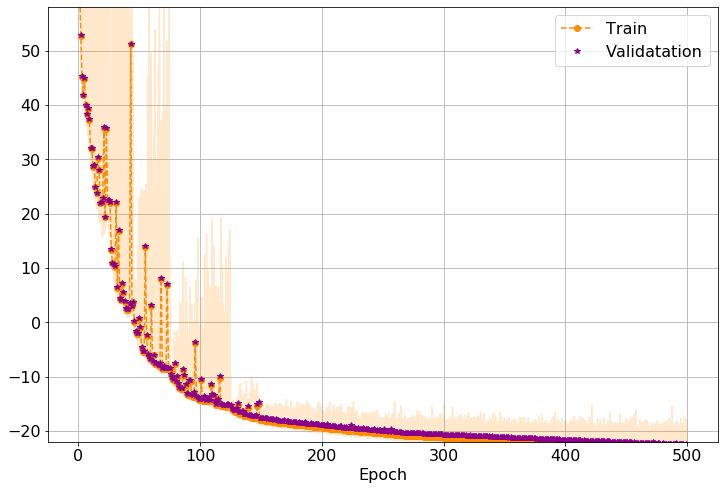

In [19]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

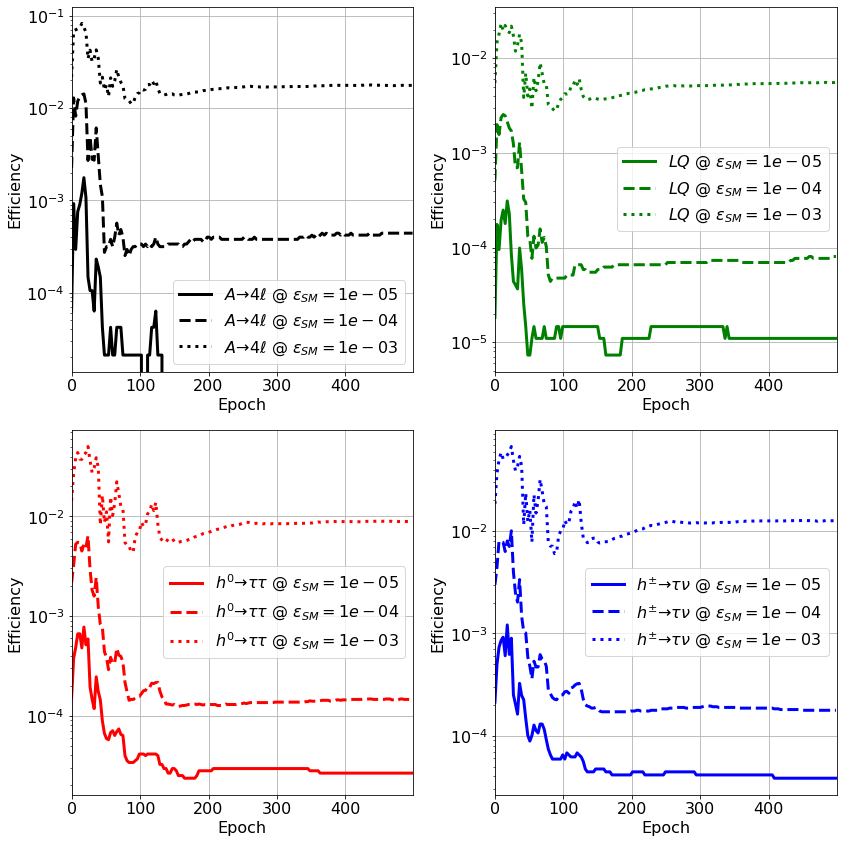

In [20]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

# Convergence check

In [22]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

/nfshome/ocerri/miniconda2/envs/PartAN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


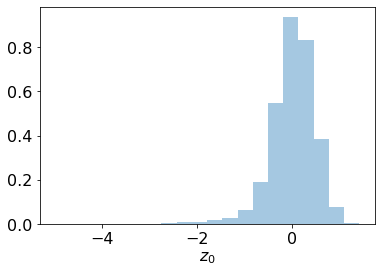

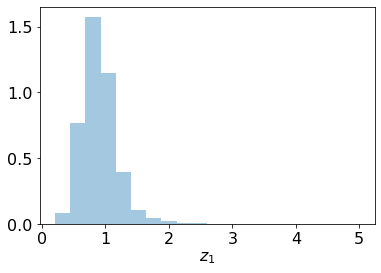

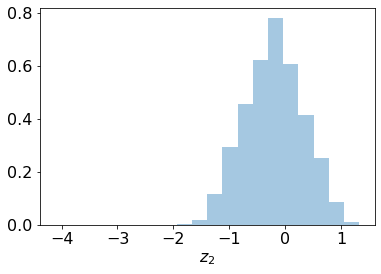

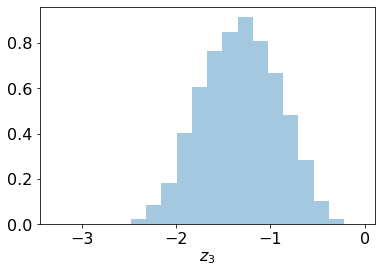

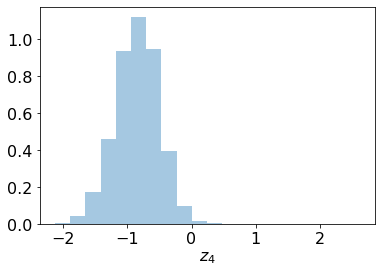

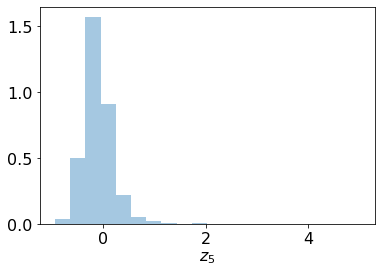

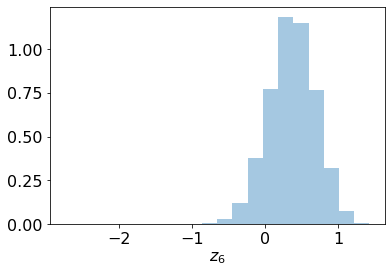

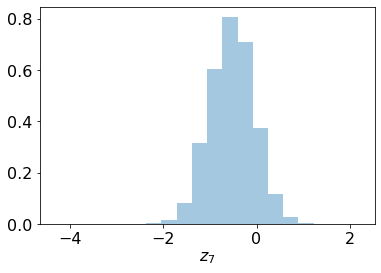

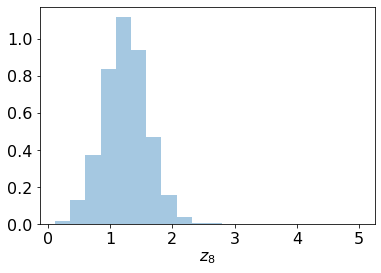

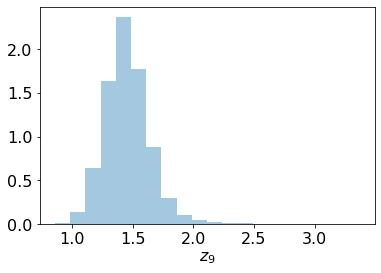

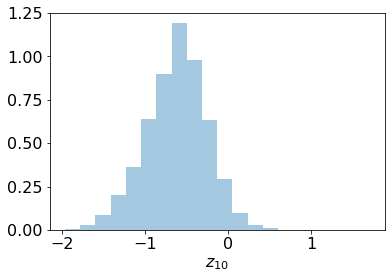

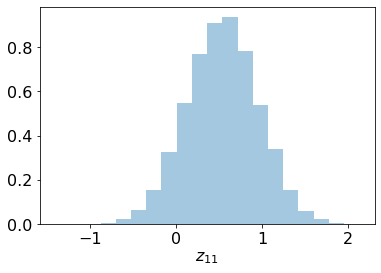

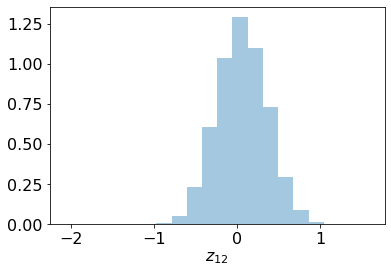

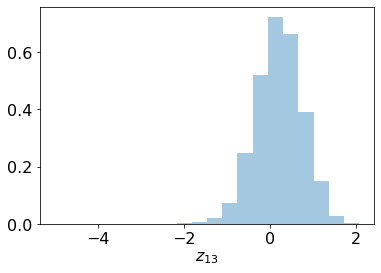

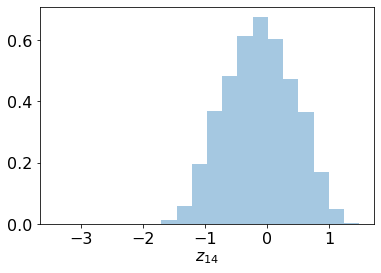

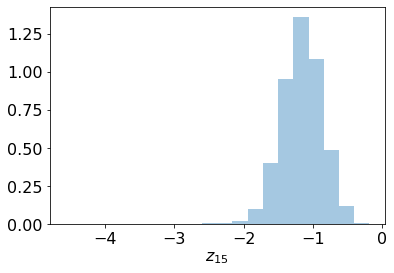

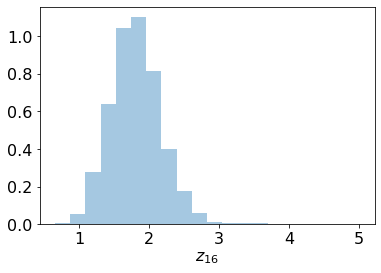

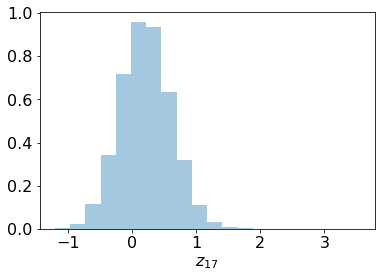

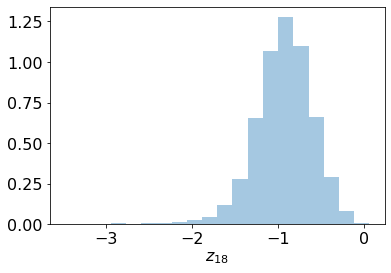

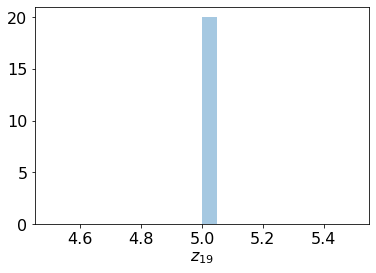

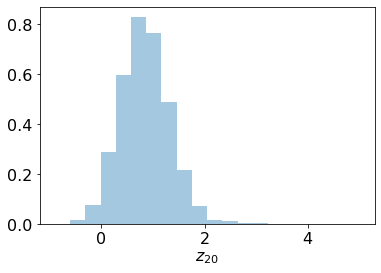

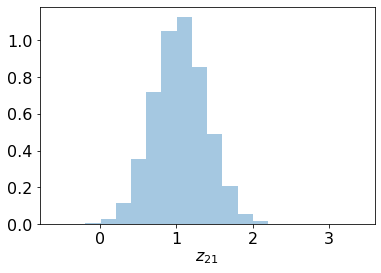

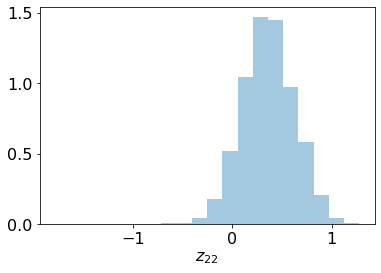

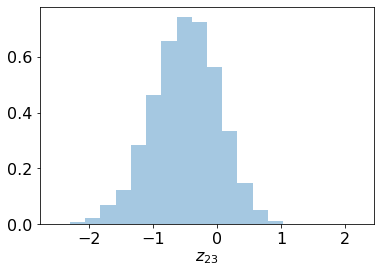

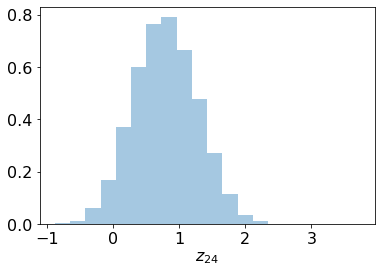

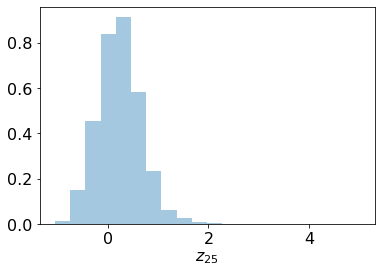

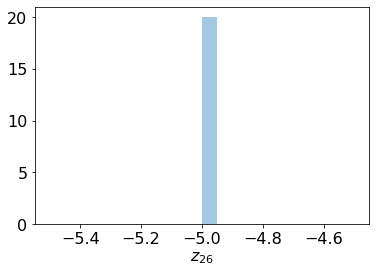

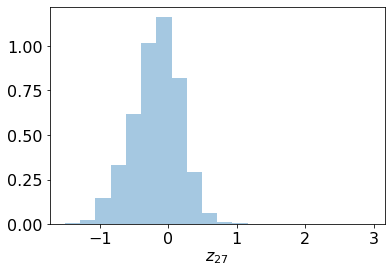

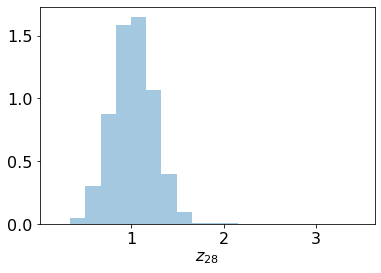

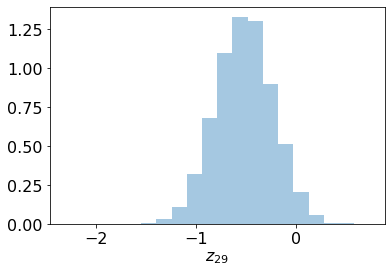

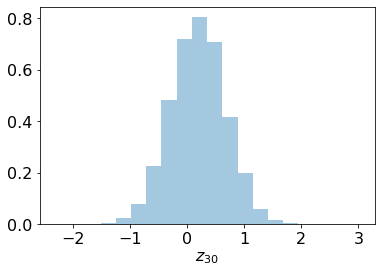

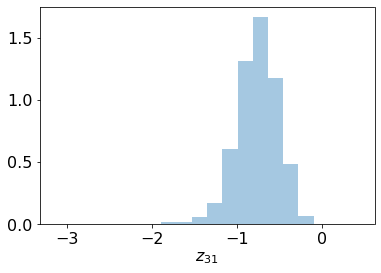

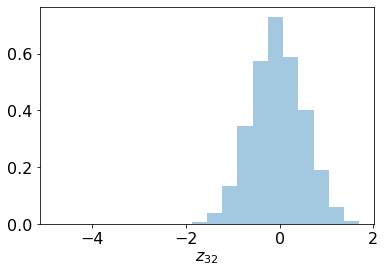

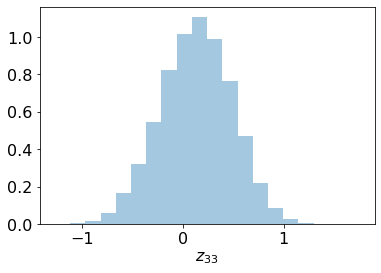

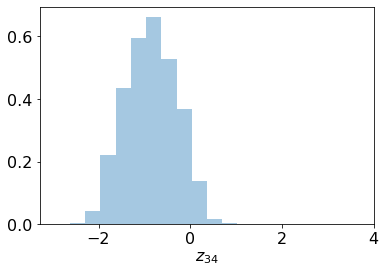

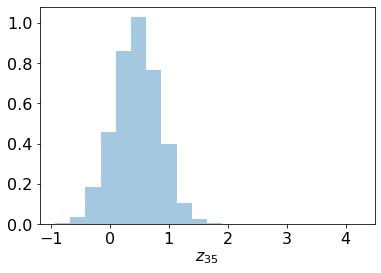

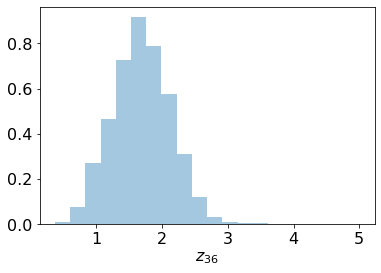

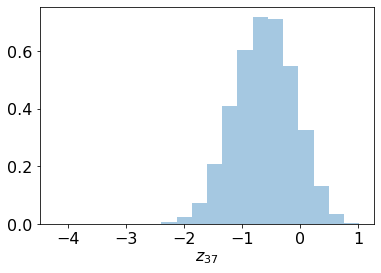

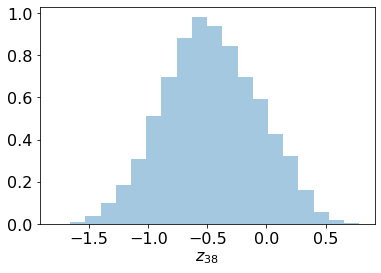

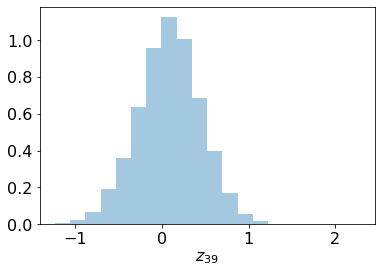

In [23]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

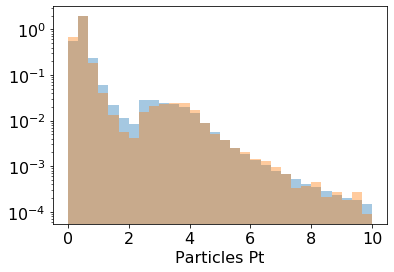

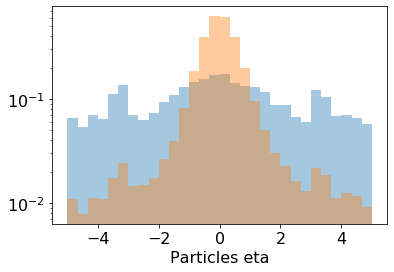

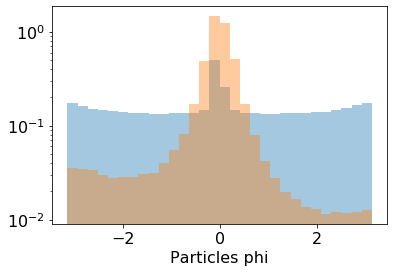

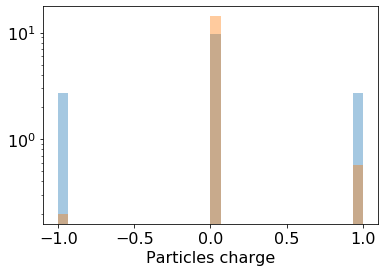

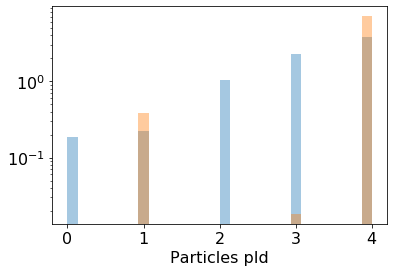

In [24]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
    plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [25]:
dataset.loadValidationSamples('SM')

Loading Wlnu (2000.0k)
Loading qcd (1141.9k)
Loading Zll (773.6k)
Loading ttbar (989.9k)
SM Mix limiting stat. sample: qcd (1.14M)
SM validation weights
[('Wlnu', 0.99999921893491114253), ('qcd', 1.0), ('Zll', 0.29257605781977745954), ('ttbar', 0.010238898454774046649)]


In [26]:
model.eval()
for n in dataset.valSamples.keys():
    dataset.loss[n] = np.zeros((0))
    
    dataset.charge(dataset.valSamples[n])
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.2 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
Wlnu: [####################]  100% - Tot. time: 11.7 s
qcd: [####################]  100% - Tot. time: 6.1 s
Zll: [################]  100% - Tot. time: 3.8 s
ttbar: [####################]  100% - Tot. time: 5.4 s


In [27]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

CumSum accuracy: 1.0000000000000259674


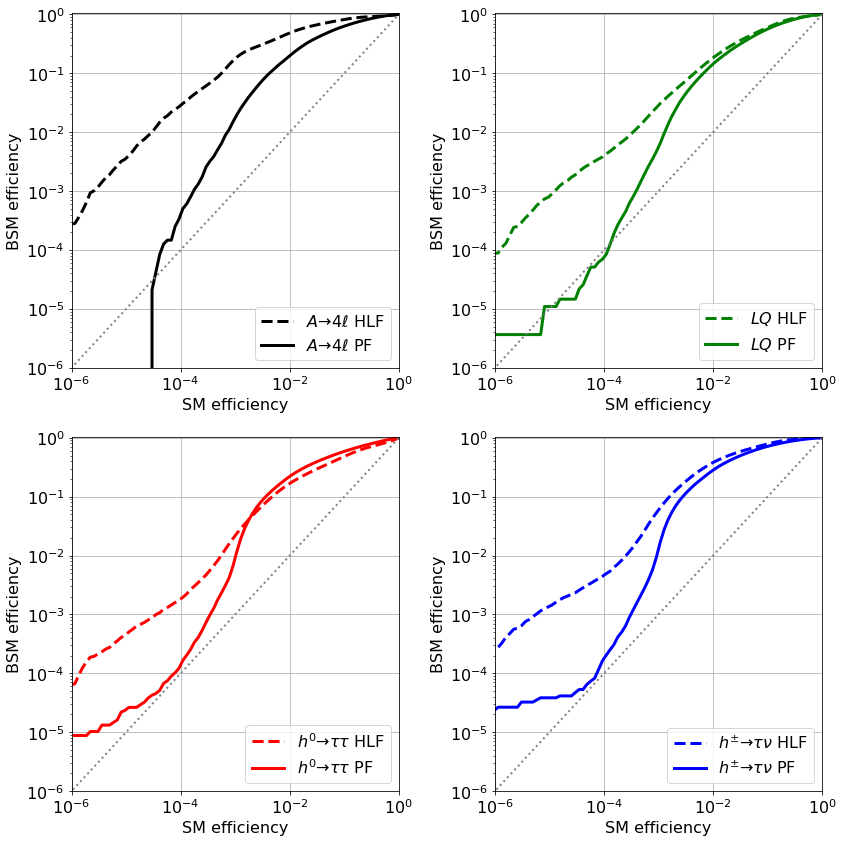

In [28]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [29]:
from sklearn.manifold import TSNE

In [30]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [31]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

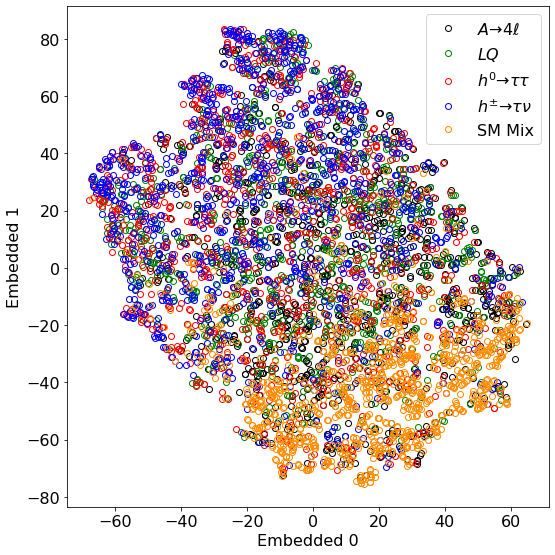

In [32]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()